<a href="https://colab.research.google.com/github/weiyunna/Deep-Learning-with-Tensorflow/blob/master/Transfer_Learning_with_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with ResNet 50

This kernel is intended to be a tutorial on Keras around image files handling for Transfer Learning using pre-trained weights from ResNet50 convnet.

Though loading all train & test images resized (224 x 224 x 3) in memory would have incurred ~4.9GB of memory, the plan was to batch source image data during the training, validation & testing pipeline. Keras ImageDataGenerator supports batch sourcing image data for all training, validation and testing. Actually, it is quite clean and easy to use Keras ImageDataGenerator except few limitations (listed at the end).

Keras ImageDataGenerator expects labeled training images to be available in certain folder heirarchy, 'train' data was manually split into 10k for training & 2.5k for validation and re-arranged into the desired folder hierarchy. Even 'test' images had to rearranged due to a known issue in flow_from_directory.

In [0]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

import cv2

import os

In [2]:
import tensorflow as tf
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense


print(tf.__version__)

1.13.1


## Connect with the Google Drive

In [33]:
import os
print(os.listdir("."))

['The Hello World of Neural Network', 'Week1', 'Week1-Exercise1', 'Week2-Computer Vision on Fashion MINST', 'MINST Digits Recognition', 'Improving Computer Vision Accuracy using Convolutions', 'CNN_Filters and Pools', 'Horse or Human - Image Classification', 'Face Recognition', 'An End-to-End-Data-Science-Framework', 'Azure-aml-real-time-ai', 'Introduction to Pandas', 'First-Steps-With-Tensorflow', 'Introduction to Keras', 'Introduction to Neural Nets', 'Introduction to Matplotlib', 'Images', 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 'best.hdf5', 'Introduction to Bokeh', 'Transfer Learning with ResNet50']


In [4]:
# Authorization

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131294 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.3-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.3-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.3-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [5]:
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:

# Mount drive to "drive/" folder

!mkdir -p drive
!google-drive-ocamlfuse drive

In [7]:
print(os.listdir("drive/Colab Notebooks/"))
os.chdir("drive/Colab Notebooks/")

['The Hello World of Neural Network', 'Week1', 'Week1-Exercise1', 'Week2-Computer Vision on Fashion MINST', 'MINST Digits Recognition', 'Improving Computer Vision Accuracy using Convolutions', 'CNN_Filters and Pools', 'Horse or Human - Image Classification', 'Face Recognition', 'An End-to-End-Data-Science-Framework', 'Azure-aml-real-time-ai', 'Introduction to Pandas', 'First-Steps-With-Tensorflow', 'Introduction to Keras', 'Introduction to Neural Nets', 'Introduction to Matplotlib', 'Images', 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 'Introduction to Bokeh', 'Transfer Learning with ResNet50']


In [8]:
print(os.listdir("."))

['Introduction to Neural Nets', 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 'Introduction to Pandas', 'Azure-aml-real-time-ai', 'The Hello World of Neural Network', 'Introduction to Matplotlib', 'Transfer Learning with ResNet50', 'Improving Computer Vision Accuracy using Convolutions', 'An End-to-End-Data-Science-Framework', 'Horse or Human - Image Classification', 'MINST Digits Recognition', 'Week2-Computer Vision on Fashion MINST', 'Week1', 'CNN_Filters and Pools', 'Week1-Exercise1', 'Face Recognition', 'Introduction to Keras', 'First-Steps-With-Tensorflow', 'Introduction to Bokeh', 'Images']


## Define the Global Constants

In [0]:
# Fixed for our Cats & Dogs classes
NUM_CLASSES = 2

# Fixed for Cats & Dogs color images
CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 3

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1

## ResNet50

* Notice that resnet50 folder has 2 pre-trained weights files... xyz_tf_kernels.h5 & xyz_tf_kernels_NOTOP.h5

* The xyz_tf_kernels.h5 weights is useful for pure prediction of test image and this prediction will rely completely on ResNet50 pre-trained weights, i.e., it does not expected any training from our side

* Out intention in this kernel is Transfer Learning by using ResNet50 pre-trained weights except its TOP layer, i.e., the xyz_tf_kernels_NOTOP.h5 weights... Use this weights as initial weight for training new layer using train images

In [0]:
resnet_weights_path = 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

## Define Our Transfer Learning Network Model Consisting of 2 Layers
Here, we are preparing specification or blueprint of the TensorFlow DAG (directed acyclcic graph) for just the MODEL part.

In [15]:
#Still not talking about our train/test data or any pre-processing.

model = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = resnet_weights_path))

# 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

Instructions for updating:
Colocations handled automatically by placer.


In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


## Compile Our Transfer Learning Model

In [0]:
from tensorflow.python.keras import optimizers

sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

## Prepare Keras Data Generators

Keras `ImageDataGenerator(...)` generates batches of tensor image data with real-time data augmentation. The data will be looped over (in batches). It is useful with large dataset to source, pre-process (resize, color conversion, image augmentation, batch normalize) & supply resulting images in batches to downstream Keras modeling components, namely `fit_generator(...)` &` predict_generator(...) `-vs- `fit(...)` & `predict(...)` for small dataset.

Kaggle competition rule expects Dog & Cat to be labeled as 1 & 0. Keras >> `ImageDataGenerator >> flow_from_directory` takes in 'classes' list for mapping it to LABEL indices otherwise treats sub-folders enumerated classes in alphabetical order, i.e., Cat is 0 & Dog is 1.

In [18]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

image_size = IMAGE_RESIZE

# preprocessing_function is applied on each image but only after re-sizing & augmentation (resize => augment => pre-process)
# Each of the keras.application.resnet* preprocess_input MOSTLY mean BATCH NORMALIZATION (applied on each batch) stabilize the inputs to nonlinear activation functions
# Batch Normalization helps in faster convergence
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

# flow_From_directory generates batches of augmented data (where augmentation can be color conversion, etc)
# Both train & valid folders must have NUM_CLASSES sub-folders
train_generator = data_generator.flow_from_directory(
        'Images/Train',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
        'Images/Validation',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical') 

Using TensorFlow backend.


Found 202 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [19]:
# Max number of steps that these generator will have opportunity to process their source content
# len(train_generator) should be 'no. of available train images / BATCH_SIZE_TRAINING'
# len(valid_generator) should be 'no. of available train images / BATCH_SIZE_VALIDATION'
(BATCH_SIZE_TRAINING, len(train_generator), BATCH_SIZE_VALIDATION, len(validation_generator))

(100, 3, 100, 1)

Train Our Model With Cats & Dogs Train (splitted) Data Set

In [0]:
# Early stopping & checkpointing the best model in ../working dir & restoring that as our model for prediction
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = 'best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [0]:
# Grid Search is an ideal candidate for distributed machine learning
# Pseudo code for hyperparameters Grid Search
#import sklearn
#import sklearn.grid_search
#from sklearn.grid_search import ParameterGrid
#param_grid = {'epochs': [5, 10, 15], 'steps_per_epoch' : [10, 20, 50]}

#grid = ParameterGrid(param_grid)

# Accumulate history of all permutations (may be for viewing trend) and keep watching for lowest val_loss as final model
#for params in grid:
   # print(params)
```

In [24]:
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer, cb_early_stopper]
)
model.load_weights("best.hdf5")

Epoch 1/10
3/3 [==============================] - 88s 29s/step - loss: 0.1072 - acc: 0.9554 - val_loss: 0.0602 - val_acc: 0.9900
Epoch 2/10
3/3 [==============================] - 88s 29s/step - loss: 0.0400 - acc: 0.9901 - val_loss: 0.0176 - val_acc: 0.9900
Epoch 3/10
3/3 [==============================] - 88s 29s/step - loss: 0.0098 - acc: 0.9950 - val_loss: 0.0103 - val_acc: 0.9900
Epoch 4/10
3/3 [==============================] - 84s 28s/step - loss: 0.0192 - acc: 0.9901 - val_loss: 0.0173 - val_acc: 0.9900
Epoch 5/10
3/3 [==============================] - 84s 28s/step - loss: 0.0980 - acc: 0.9851 - val_loss: 0.0884 - val_acc: 0.9800
Epoch 6/10
3/3 [==============================] - 84s 28s/step - loss: 0.5400 - acc: 0.9010 - val_loss: 0.3179 - val_acc: 0.9000


## Training Metrics
One of the default callbacks that is registered when training all deep learning models is the History callback. It records training metrics (training accuracy, training loss, validation loss & validation accuracy) for each epoch. Note that training accuracy & loss during epoch steps are somewhat incomplete information and they are not recorded in history.

Observe that training uses early stopping, hence metrics is available for epochs run, not for NUM_EPOCHS.

In [25]:
print(fit_history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


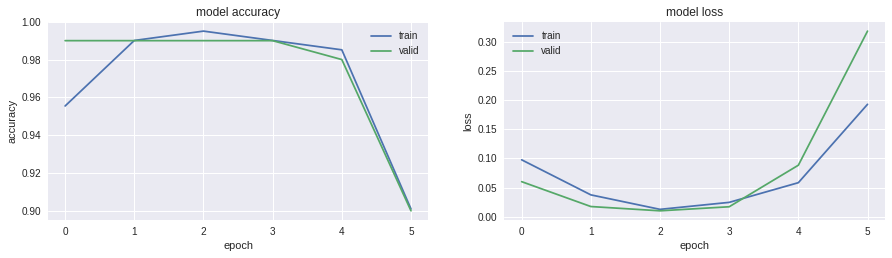

In [26]:
 plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['acc'])  
plt.plot(fit_history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [34]:
# NOTE that flow_from_directory treats each sub-folder as a class which works fine for training data
# Actually class_mode=None is a kind of workaround for test data which too must be kept in a subfolder

# batch_size can be 1 or any factor of test dataset size to ensure that test dataset is samples just once, i.e., no data is left out
test_generator = data_generator.flow_from_directory(
    directory = 'Images/Test/test',
    target_size = (image_size, image_size),
    batch_size = BATCH_SIZE_TESTING,
    class_mode = None,
    shuffle = False,
    seed = 123
)

Found 0 images belonging to 0 classes.


## Observe Prediction Time With Different Batch Size
With GPU, 97s for full prediction with batch_size=100 -vs- 264s with 1. But note that to avoid ImageDataGenerator iterator repeatability, we need to use 1 as batch_size.

In [30]:
# Reset before each call to predict
test_generator.reset()

pred = model.predict_generator(test_generator, steps = len(test_generator), verbose = 1)

predicted_class_indices = np.argmax(pred, axis = 1)

  4/100 [>.............................] - ETA: 1:05

FileNotFoundError: ignored

error: ignored

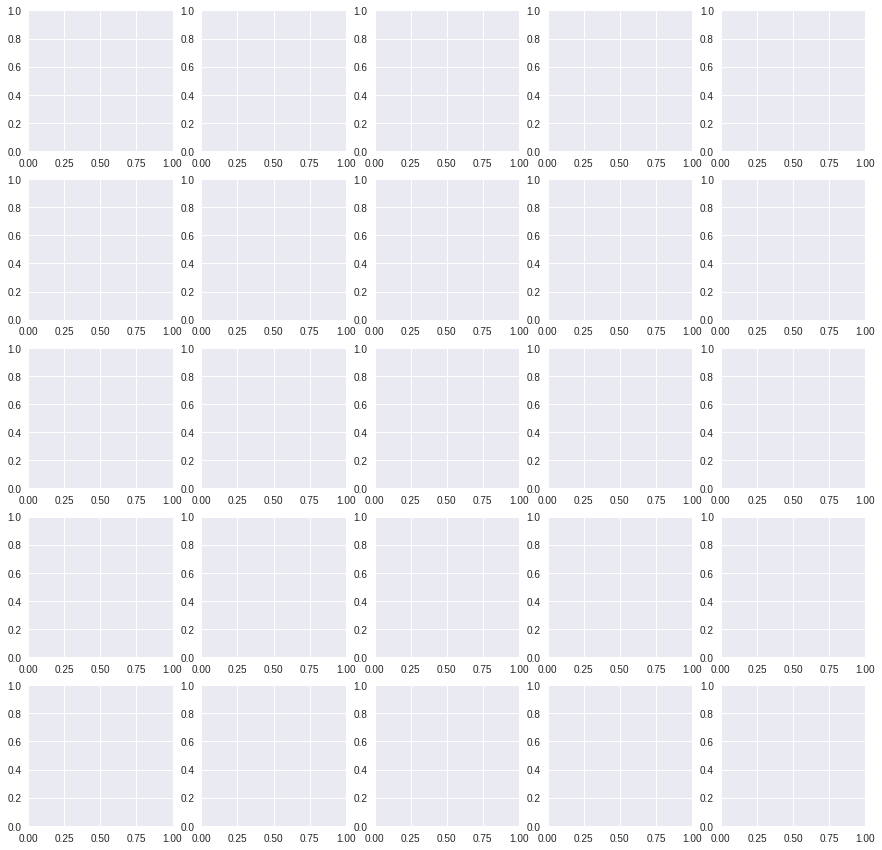

In [29]:
TEST_DIR = 'Images/Test'
f, ax = plt.subplots(5, 5, figsize = (15, 15))

for i in range(0,25):
    imgBGR = cv2.imread(TEST_DIR + test_generator.filenames[i])
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
    
    # a if condition else b
    predicted_class = "Dog" if predicted_class_indices[i] else "Cat"

    ax[i//5, i%5].imshow(imgRGB)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(predicted_class))    

plt.show()